In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic functionality on a graph

After importing a Raphtory graph we can create a blank one to work with:

* Graphs in Raphtory are directed by default


In [2]:
from raphtory import Graph
g = Graph() 

Once we have a new graph we can add vertices and edges to it via `add_vertex()` and `add_edge()`. For these:
* The ids of vertices and the source/destination of an edge can be either strings or integers
* All additions into the graph must happen at a specific time - this means updates are also additions
* If you add an edge between vertices which do no exist in the graph yet, these will be automatically created
* Properties can be added onto vertices and edges - this is a dict of any value, but the keys must be strings
* We have a special type of `static property` which exists outside of the timeline and is always accessible. 
* Additions can be completed out of order, making it very easy to merge datasets together


We can then check the state of the graph:
* To see if a vertex or edge exists you can use `has_vertex()` and `has_edge()`
* To get the earliest and latest times at which updates have been applied to the graph you can use `earliest_time()` and `latest_time()` - if no updates have been applied these will return `None`
* To get the total number of vertices and edges of a graph you can use `num_edges()` and `num_vertices()`.

In [3]:
# Basic Addition with integer IDs
g.add_vertex(timestamp=1,id=10)
g.add_edge(timestamp=2,src=1,dst=2)

# checking vertex 10, 1 and 5 exist 
print(g.has_vertex(10), g.has_vertex(1), g.has_vertex(5))
# checking edge 1,2 exists and 2,1 doesn't as Raphtory is directed
print(g.has_edge(1,2),g.has_edge(2,1))
# Check the total number of edges and vertices
print(g.num_edges(),g.num_vertices())

# Adding vertices and edges with String IDs
g.add_vertex(timestamp=5,id="Ben")
g.add_edge(timestamp=8,src="Hamza",dst="Ben")

# Performing the same checks as before, but with strings
print(g.has_vertex(id="Ben"), g.has_vertex(id="Hamza"), g.has_vertex(id="Dave"))
print(g.has_edge(src="Hamza",dst="Ben"),g.has_edge(src="Ben",dst="Hamza"))
print(g.num_edges(),g.num_vertices())

#Add an edge with Temporal Properties which can change over time
g.add_edge(timestamp=7,src="Haaroon",dst="Hamza",properties={"property1": 1, "property2": 9.8, "property3": "test"})
#Add a static property which is immutable
g.add_edge_properties(src="Haaroon",dst="Hamza",properties={"First-Met":"01/01/1990"})

#Add an vertex with Temporal Properties which can change over time
g.add_vertex(timestamp=5,id="Hamza",properties= {"property1": 5, "property2": 12.5, "property3": "test2"})
#Add a static property which is immutable
g.add_vertex_properties(id="Hamza",properties={"Date-of-Birth":"01/01/1990"})

g.save_to_file("/tmp/graph")

loaded_graph = Graph.load_from_file("/tmp/graph")

print(loaded_graph.has_vertex("Hamza"))


True True False
True False
1 3
True True False
True False
2 5
True


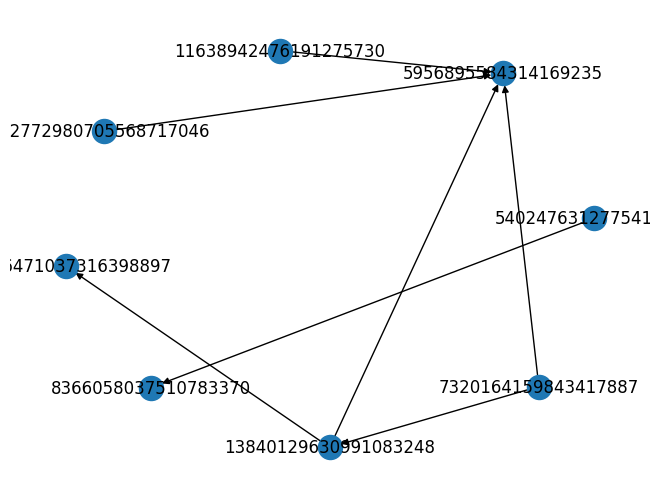

In [4]:
from raphtory import graph_loader

g = graph_loader.lotr_graph()
view = g.at(300)
g.add_vertex(timestamp=0,id="Gandalf",properties={"Race":"Maiar"})

view["Gandalf"]["Race"]
from raphtory import plot

plot.draw(view, with_labels=True)

<Axes: xlabel='degree', ylabel='Count'>

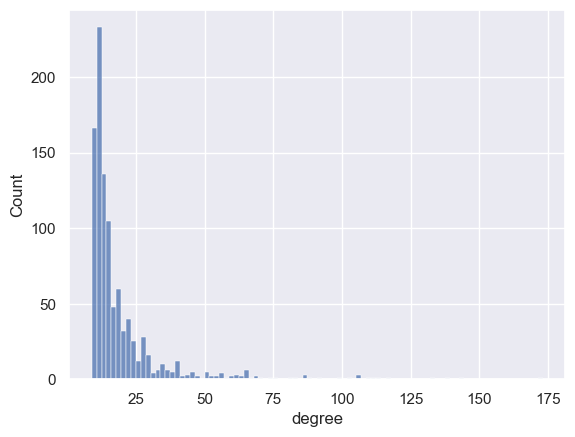

In [5]:
from raphtory import graph_gen

g = Graph(4)
graph_gen.ba_preferential_attachment(g,vertices_to_add=1000,edges_per_step=10)
view = g.window(0,1000)

ids = []
degrees = []
for v in view.vertices():
    ids.append(v.id)
    degrees.append(v.degree())

df = pd.DataFrame.from_dict({"id":ids,"degree": degrees})

sns.set()
sns.histplot(df.degree)

In [6]:
from raphtory import Graph
from raphtory import algorithms
from raphtory import Perspective

g = graph_loader.lotr_graph()
views = g.through(Perspective.rolling(1000))

for view in views:
    print(view.num_edges(),view.num_vertices())


20 23
44 21
20 9
16 9
17 11
45 21
44 29
84 37
68 26
41 19
38 19
49 19
38 22
28 18
5 7
19 14
18 13
24 13
20 14
17 14
5 5
15 11
30 14
22 10
13 10
48 26
86 33
48 30
134 39
22 16
78 28
214 49
38 17


<Axes: xlabel='Time', ylabel='Average Interactions'>

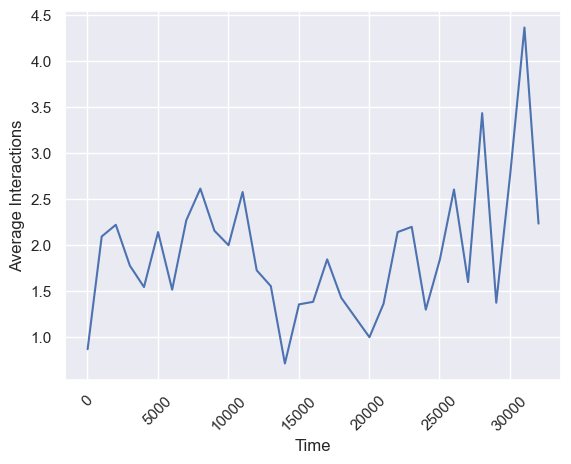

In [7]:
p = Perspective.rolling(window=1000) 
views = g.through(p) 

timestamps   = []
vertex_count = []
edge_count   = []
degree      = []

for view in views:
    timestamps.append(view.earliest_time())
    #vertex_count.append(view.num_vertices())             
    #edge_count.append(view.num_edges())
    degree.append(view.num_edges()/view.num_vertices())             
             
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Average Interactions")
sns.lineplot(x = timestamps, y = degree,ax=ax) 

<Axes: xlabel='Time', ylabel='Interactions'>

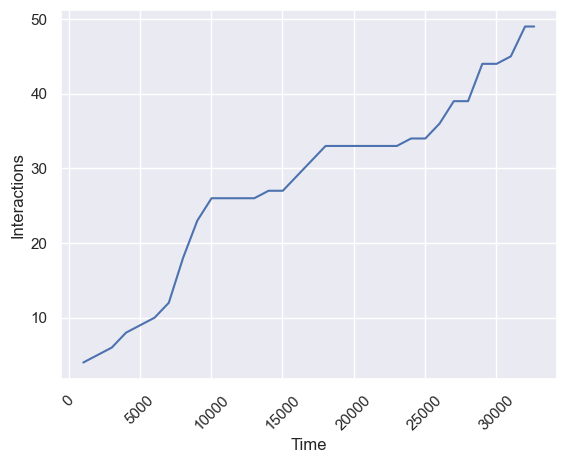

In [8]:
p = Perspective.expanding(step=1000) 
views = g.through(p) 

timestamps   = []
degree       = []

for view in views:
    timestamps.append(view.latest_time())
    gandalf = view.vertex("Gandalf")

    if(gandalf is not None):
        degree.append(gandalf.degree())
    else:
        degree.append(0)
            
             
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Interactions")
sns.lineplot(x = timestamps, y = degree,ax=ax) 